In [19]:
import sys
import tqdm
import torch
import numpy as np
import scanpy as sc
import seaborn as sns
import pyarrow.parquet as pq

from matplotlib import pyplot as plt
from transformers import T5Tokenizer, T5EncoderModel

torch.set_float32_matmul_precision('medium')

In [2]:
parquet_path = "../data/frustration/v8_frustration_v2.parquet.gzip"
df = pq.read_table(parquet_path).to_pandas()
df = df.sample(n=100, random_state=42).reset_index(drop=True)

## ProstT5

In [102]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
pLM_model = "../data/prostT5"
prefix_prostT5 = "<AA2fold>"
max_seq_length = 256
tokenizer = T5Tokenizer.from_pretrained(pLM_model, do_lower_case=False, max_length=max_seq_length)
encoder = T5EncoderModel.from_pretrained(pLM_model).to(device)

if "cuda" in device:
    encoder.half()
    print("Using half precision for the pLM encoder")

In [103]:
frust_avail = []
embeddings = []
res_labels = []
frst_val = []
frst_class = []

for row in tqdm.tqdm(df.iterrows()):
    idx = min(len(row[1]["full_seq"]), max_seq_length)

    full_seq = [prefix_prostT5 + " " + " ".join(seq) for seq in [row[1]["full_seq"]]]  # Add spaces between amino acids and prefix
    ids = tokenizer.batch_encode_plus(full_seq,
                                    add_special_tokens=True,
                                    max_length=max_seq_length,
                                    padding="max_length",
                                    truncation="longest_first",
                                    return_tensors='pt'
                                    ).to(device)

    with torch.no_grad():
        embedding_rpr = encoder(
            ids.input_ids,
            attention_mask=ids.attention_mask
        )
    emb = embedding_rpr.last_hidden_state[0, 1:idx,]
    embeddings.append(emb)
    res_labels.append(list(row[1]["full_seq"])[:idx-1])

    frsts = torch.zeros((len(row[1]["full_seq"])), dtype=torch.bool)
    frsts[row[1]["res_idx"]] = True
    frust_avail.append(frsts[:idx-1])
    vals = np.zeros((len(row[1]["full_seq"])))
    vals[:] = np.nan
    vals[row[1]["res_idx"]] = row[1]["frst_idx"]
    frst_val.append(vals[:idx-1])
    classes = np.zeros((len(row[1]["full_seq"])), dtype=object)
    classes[row[1]["res_idx"]] = row[1]["frst_class"]
    frst_class.append(classes[:idx-1])


100it [00:34,  2.88it/s]


In [104]:
adata = sc.AnnData(X=torch.cat(embeddings, dim=0).cpu().numpy())
adata.obs['frustration'] = torch.cat(frust_avail, dim=0).cpu().numpy()
adata.obs['residue'] = np.concatenate(res_labels, axis=0)
adata.obs['frst_val'] = np.concatenate(frst_val, axis=0)
adata.obs['frst_class'] = np.concatenate(frst_class, axis=0)
adata.obs['frst_class'] = adata.obs['frst_class'].astype('category')

In [105]:
adata

AnnData object with n_obs × n_vars = 24481 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class'

In [106]:
adata_frst = adata[adata.obs['frustration'] == True, :].copy()
adata_frst

AnnData object with n_obs × n_vars = 10997 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class'

In [107]:
sc.pp.pca(adata_frst)
sc.pp.neighbors(adata_frst)
sc.tl.umap(adata_frst)

In [108]:
property_dict = {
    'A': 'hydrophobic', 'V': 'hydrophobic', 'I': 'hydrophobic', 'L': 'hydrophobic', 'M': 'moderate',
    'F': 'hydrophobic', 'Y': 'hydrophobic', 'W': 'hydrophobic',
    'R': 'positive', 'H': 'positive', 'K': 'positive',
    'D': 'negative', 'E': 'negative',
    'S': 'hydrophilic', 'T': 'hydrophilic', 'N': 'hydrophilic', 'Q': 'hydrophilic',
    'C': 'special', 'G': 'special', 'P': 'special'
}

In [109]:
adata_frst.obs['residue_property'] = adata_frst.obs['residue'].map(property_dict)

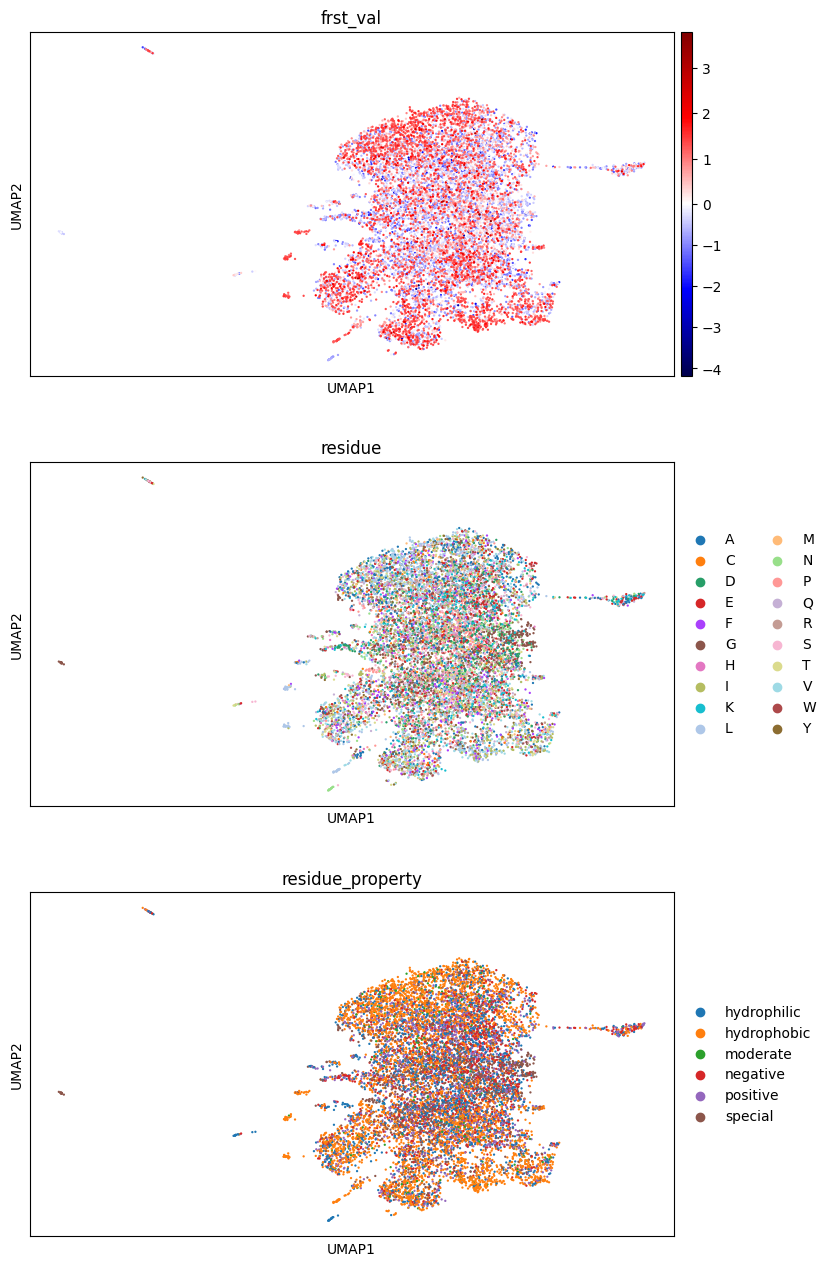

In [110]:
sc.pl.umap(adata_frst, color=['frst_val', 'residue', "residue_property"], ncols=1, wspace=0.4, cmap='seismic', vcenter=0,) #palette="tab20")

In [73]:
len(df.iloc[0]["full_seq"])

309

In [74]:
full_seq = [prefix_prostT5 + " " + " ".join(df.iloc[0]["full_seq"])]
ids = tokenizer.batch_encode_plus(full_seq,
                                add_special_tokens=True,
                                max_length=max_seq_length,
                                padding="max_length",
                                truncation="longest_first",
                                return_tensors='pt'
                                ).to(device)

with torch.no_grad():
    embedding_rpr = encoder(
        ids.input_ids,
        attention_mask=ids.attention_mask
    )
emb = embedding_rpr.last_hidden_state[0, 1:,]
emb.shape

torch.Size([255, 1024])

In [75]:
adata_dummy = sc.AnnData(X=emb.cpu().numpy())
adata_dummy.obs['residue'] = list(df.iloc[0]["full_seq"])[:max_seq_length-1]
adata_dummy.obs['residue'] = adata_dummy.obs['residue'].astype('category')
adata_dummy

AnnData object with n_obs × n_vars = 255 × 1024
    obs: 'residue'

In [82]:
df.iloc[0]["full_seq"][254]

'D'

In [76]:
adata_dummy.obs

,residue
0,M
1,S
2,S
3,Q
4,P
...,...
250,R
251,L
252,D
253,T


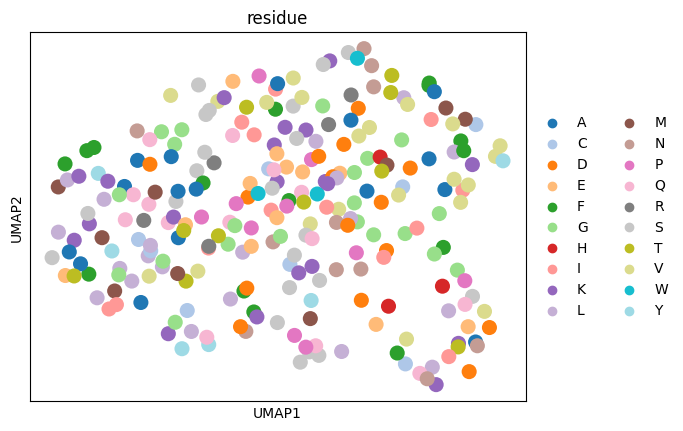

In [77]:
sc.pp.neighbors(adata_dummy, use_rep='X')
sc.tl.umap(adata_dummy)
sc.pl.umap(adata_dummy, color=['residue'], palette="tab20")

## ProtT5

In [6]:
df.head(2)

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,frst_class_3,split_test,cath_id,cath_T_id,split_old,split_0,split_1,split_2,split_3
0,AF-A0A840LZX6-F1-model_v4_TED01,MIFQARPRPVLPSFADHGRSTGAHHYDVVIIGGGYTGLSTARYLAQ...,"[P, S, F, A, D, H, G, R, S, T, G, A, H, H, Y, ...","[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2...","[-0.142, -0.305, 0.829, -1.228, 2.168, 1.148, ...","[f11, f11, f9, f13, f6, f8, f10, f7, f10, f10,...","[1, 1, 2, 0, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, ...",train,3.50.50.60,3.50.50,train,train,train,train,val
1,AF-A0A1U7RT13-F1-model_v4_TED01,MATKSRKYRALSELLPFQSSSDRKGCFALPRSSATTHRSRCGEEKC...,"[S, L, I, S, N, H, S, R, Y, V, E, S, F, R, L, ...","[88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 9...","[-0.645, 0.784, 0.539, -0.408, -0.947, -0.16, ...","[f12, f9, f9, f11, f13, f11, f11, f11, f9, f8,...","[1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, ...",train,3.40.50.150,3.40.50,train,train,train,train,train


In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
pLM_model = "../data/protT5"
max_seq_length = 256
tokenizer = T5Tokenizer.from_pretrained(pLM_model, do_lower_case=False, max_length=max_seq_length)
encoder = T5EncoderModel.from_pretrained(pLM_model).to(device)

if "cuda" in device:
    encoder.half()
    print("Using half precision for the pLM encoder")

In [7]:
frust_avail = []
embeddings = []
res_labels = []
frst_val = []
frst_class = []

for row in tqdm.tqdm(df.iterrows()):
    idx = min(len(row[1]["full_seq"]), max_seq_length)

    full_seq = [" ".join(seq) for seq in [row[1]["full_seq"]]]  # Add spaces between amino acids and prefix
    ids = tokenizer.batch_encode_plus(full_seq,
                                    add_special_tokens=True,
                                    max_length=max_seq_length,
                                    padding="max_length",
                                    truncation="longest_first",
                                    return_tensors='pt'
                                    ).to(device)

    with torch.no_grad():
        embedding_rpr = encoder(
            ids.input_ids,
            attention_mask=ids.attention_mask
        )
    emb = embedding_rpr.last_hidden_state[0, :idx,]
    embeddings.append(emb)
    res_labels.append(list(row[1]["full_seq"])[:idx])

    frsts = torch.zeros((len(row[1]["full_seq"])), dtype=torch.bool)
    frsts[row[1]["res_idx"]] = True
    frust_avail.append(frsts[:idx])
    vals = np.zeros((len(row[1]["full_seq"])))
    vals[:] = np.nan
    vals[row[1]["res_idx"]] = row[1]["frst_idx"]
    frst_val.append(vals[:idx])
    classes = np.zeros((len(row[1]["full_seq"])), dtype=object)
    classes[row[1]["res_idx"]] = row[1]["frst_class_3"]
    frst_class.append(classes[:idx])


100it [00:32,  3.12it/s]


In [8]:
adata = sc.AnnData(X=torch.cat(embeddings, dim=0).cpu().numpy())
adata.obs['frustration'] = torch.cat(frust_avail, dim=0).cpu().numpy()
adata.obs['residue'] = np.concatenate(res_labels, axis=0)
adata.obs['frst_val'] = np.concatenate(frst_val, axis=0)
adata.obs['frst_class'] = np.concatenate(frst_class, axis=0)
adata.obs['frst_class'] = adata.obs['frst_class'].astype('category')

In [9]:
adata

AnnData object with n_obs × n_vars = 24614 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class'

In [10]:
adata_frst = adata[adata.obs['frustration'] == True, :].copy()
adata_frst

AnnData object with n_obs × n_vars = 11947 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class'

In [11]:
sc.pp.pca(adata_frst)
sc.pp.neighbors(adata_frst)
sc.tl.umap(adata_frst)

In [12]:
property_dict = {
    'A': 'hydrophobic', 'V': 'hydrophobic', 'I': 'hydrophobic', 'L': 'hydrophobic', 'M': 'moderate',
    'F': 'hydrophobic', 'Y': 'hydrophobic', 'W': 'hydrophobic',
    'R': 'positive', 'H': 'positive', 'K': 'positive',
    'D': 'negative', 'E': 'negative',
    'S': 'hydrophilic', 'T': 'hydrophilic', 'N': 'hydrophilic', 'Q': 'hydrophilic',
    'C': 'special', 'G': 'special', 'P': 'special'
}

In [13]:
adata_frst.obs['residue_property'] = adata_frst.obs['residue'].map(property_dict)

In [61]:
adata_outlier_removed = adata_frst[adata_frst.obsm['X_umap'][:, 0] < 10, :].copy()
adata_outlier_removed

AnnData object with n_obs × n_vars = 11900 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class', 'residue_property'
    uns: 'pca', 'neighbors', 'umap', 'residue_colors', 'residue_property_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Text(0.5, 1.0, 'UMAP Projection of ProstT5 Embeddings Colored by Frustration Values and Amino Acids')

<Figure size 1800x900 with 0 Axes>

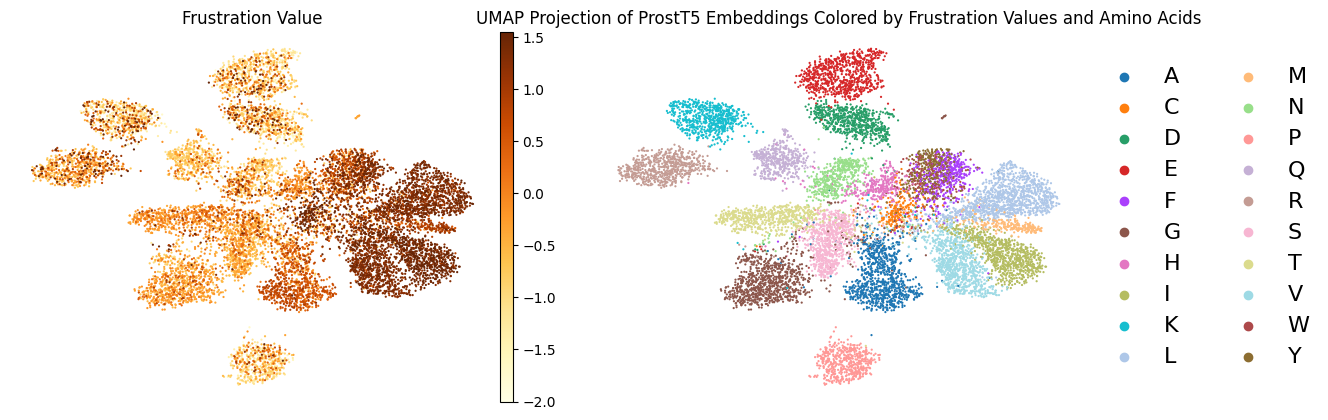

In [ ]:
plt.figure(figsize=(12,6), dpi=150)
fig = sc.pl.umap(adata_outlier_removed, color=['frst_val', 'residue',], ncols=2, wspace=0.1, cmap="YlOrBr", vmin=-2, vmax=1.55,
           frameon=False, title=['Frustration Value', 'Amino Acid'], legend_fontsize=16, return_fig=True)
plt.
#plt.savefig("umap_frustration_prostT5.png", dpi=180)

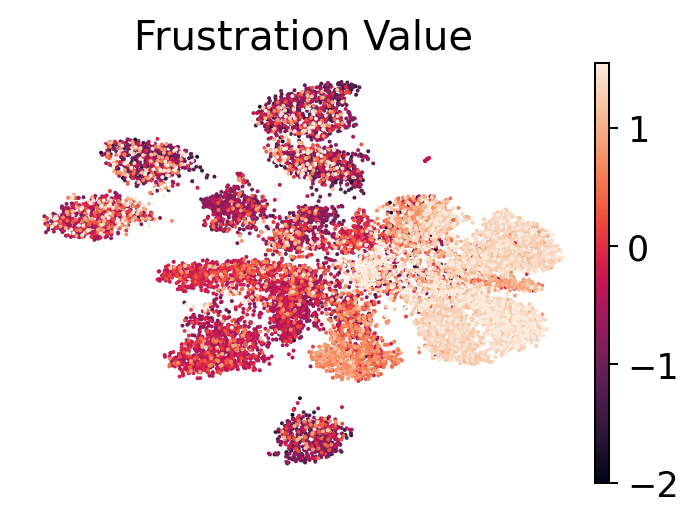

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=180)
sc.pl.umap(adata_outlier_removed, color='frst_val', cmap="rocket", vmin=-2, vmax=1.55, vcenter=np.mean([-1, 0.55]),
           ax=ax, show=False, frameon=False, legend_fontsize=16,)

ax.set_title("Frustration Value", fontsize=16)

# Fix colorbar text size
# Scanpy attaches colorbars to the figure, not the axis → iterate and modify:
for cbar in fig.axes:
    if hasattr(cbar, 'get_ylabel') and cbar is not ax:
        cbar.tick_params(labelsize=14)   # tick size
        try:
            cbar.set_ylabel(cbar.get_ylabel(), fontsize=12)
        except:
            pass

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Amino Acid')

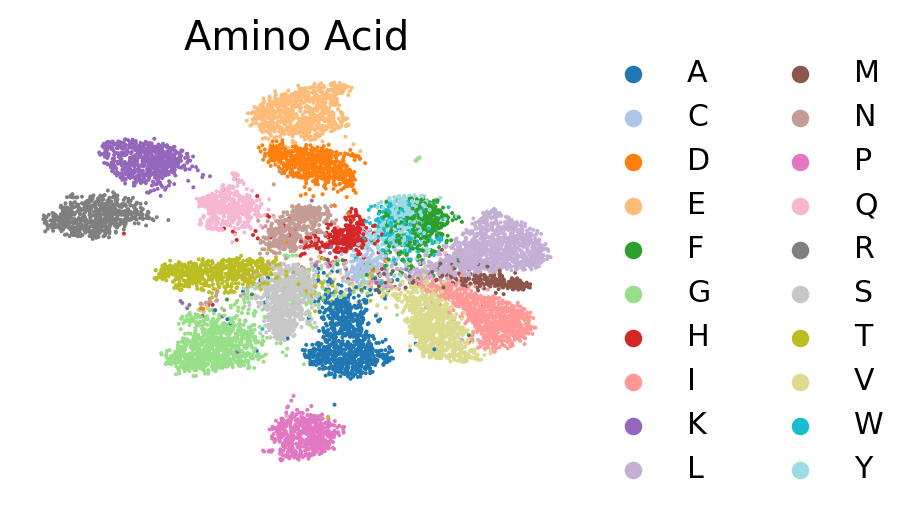

In [137]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=180)
sc.pl.umap(adata_outlier_removed, color='residue', palette="tab20",
           ax=ax, show=False, frameon=False, legend_fontsize=12,)

ax.set_title("Amino Acid", fontsize=16)

In [174]:
1 - (11900/11947)

0.0039340420189168945

In [172]:
adata_outlier_removed

AnnData object with n_obs × n_vars = 11900 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class', 'residue_property'
    uns: 'pca', 'neighbors', 'umap', 'residue_colors', 'residue_property_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

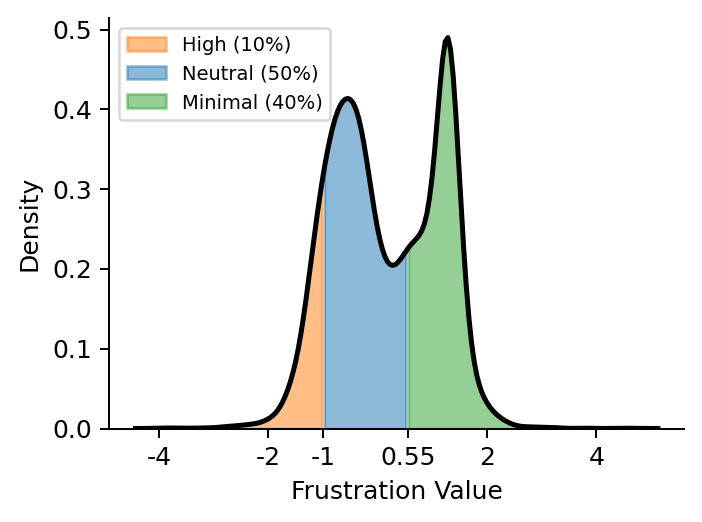

In [169]:
vals = adata_frst.obs['frst_val'].dropna()

# Plot KDE and capture the line
fig, ax = plt.subplots(figsize=(4, 3), dpi=180)
kde = sns.kdeplot(vals, fill=False, ax=ax, color="black", linewidth=2)
sns.despine(ax=ax)

# Extract the x/y data the KDE line is using
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

# Define thresholds
t1 = -1
t2 = 0.55

# Shade regions
ax.fill_between(x, y, where=(x <= t1), color="C1", alpha=0.5, label="High (10%)")
ax.fill_between(x, y, where=( (x > t1) & (x <= t2) ), color="C0", alpha=0.5, label="Neutral (50%)")
ax.fill_between(x, y, where=(x > t2), color="C2", alpha=0.5, label="Minimal (40%)")

ax.set_xlabel("Frustration Value")
ax.set_ylabel("Density")
ax.set_title("")
ax.set_xticks([-4, -2, -1, 0.55, 2, 4])
ax.set_xticklabels([-4, -2, -1, 0.55, 2, 4])
ax.legend(loc='upper left', fontsize=7.8)

plt.tight_layout()
plt.show()
